# Libraries

glove.6B (file containing GloVe embeddings) is downloaded and unzipped. "bert-exctractive-summarizer" (already built summarizer architecture), "rouge-score" (library for ROUGE metrics) and "sentence-transformers" (provides pre-trained BERT models) are installed.

In [ ]:
!wget -q http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
!pip install -q git+https://github.com/dmmiller612/bert-extractive-summarizer.git

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q rouge-score

  Preparing metadata (setup.py) ... done


In [ ]:
!pip install -q sentence-transformers

All the libraries and functions needed to execute the code in the notebok are imported.

In [ ]:
# General
import torch
import pickle
import re
import numpy as np
import random
import string
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from time import time
from tqdm.notebook import tqdm

# Preprocessing
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Models
import networkx as nx
from rouge_score import rouge_scorer
from sentence_transformers import SentenceTransformer
import xgboost as xgb
from summarizer import Summarizer
from sklearn.metrics.pairwise import cosine_similarity


import warnings
warnings.filterwarnings('ignore')

# Mounting Drive
from google.colab import drive
drive.mount('/content/drive')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


In [ ]:
# Set the base path if needed
base_path = '/content/drive/My Drive'

The custom functons defined in `Function_Setup.ipynb` are imported.

In [ ]:
import sys

sys.path.append(f'{base_path}/Text_Mining_Project_881765_933735')

from text_mining_project_utils import (get_rouge, plot_rouge)

# Importing The Data

The cleaned document and summary data created in `1_Cleaning_and_Exploration.ipynb` is loaded.

In [ ]:
with open(f'{base_path}/Text_Mining_Project_881765_933735/Data/docs', "rb") as fp:
  docs = pickle.load(fp)

In [ ]:
with open(f'{base_path}/Text_Mining_Project_881765_933735/Data/summary_labels', "rb") as fp:
  summary_labels = pickle.load(fp)

# Preprocessing

The documents and respective labels are split into sets of training and test, with the first ones being 85% of the original data.

In [ ]:
docs_train, docs_test, summary_train, summary_test = train_test_split(docs, summary_labels, train_size=0.85, shuffle=False)

Since almost all models are going to need documents split into sentences `docs_train` and `docs_test` are going to be tokenized into sentences, a copy of the two is going to be saved as `docs_train_full` and `docs_test_full`.

In [ ]:
docs_train_full = docs_train.copy()
docs_test_full = docs_test.copy()

In [ ]:
docs_train = [nltk.sent_tokenize(doc) for doc in docs_train]
docs_test = [nltk.sent_tokenize(doc) for doc in docs_test]

# Setup

Before going into the creation of the models some functions need to be created and set up to make the definition of architectures less cluttered

## Vectorizer

A Tf-idf vectorizer is fitted on all of the single sentences in the documents

In [ ]:
all_test_sents = [sent for doc in docs_train + docs_test for sent in doc]

In [ ]:
tfidf_vectorizer = TfidfVectorizer(min_df=3, max_df=0.5)
tfidf_vectorizer = tfidf_vectorizer.fit(all_test_sents)

## Normalizer

A custom list of stop words is creted and joined together with NLTK's stop word list.

In [ ]:
my_stop_words = {'say', 'be', 'said', 'says', 'saying', "cnn", "tell", "told", "also", "year", "years",
                 "people", "mr", "mrs", "ms", "report", "according", "man", "men", "woman", "women", "one", "two", "three",
                 "four", "five", "six", "seven", "eight", "nine", "ten"}

stop_words = set(nltk.corpus.stopwords.words('english'))

stop_words = stop_words.union(my_stop_words)

A `normalizer()` function is set up to strip sentences of any non alphabetic character and then to remove stop words.

In [ ]:
def normalizer(sent):
  sent = re.sub(r'[^a-zA-Z\s]', '', sent, re.I|re.A)
  sent = sent.lower()
  sent = sent.strip()
  filtered_tokens = [token for token in nltk.word_tokenize(sent) if token not in stop_words]
  processed_sent = ' '.join(filtered_tokens)
  return processed_sent

With the use of `np.vectorize()` the `normalizer()` function will be applied element-wise on each separate sentence in the document.

In [ ]:
sentence_normalizer = np.vectorize(normalizer)

This `sentence_normalizer()` function is going to be used inside the architectures to clean the sentences of the documents.

## Maximal Marginal Relevance Function

A `compute_mmr()` function is created to apply Maximum Marginal Relevance for each sentence $s_i$ not in the set of already selected sentences $S$:

$$ MMR(s_i) = λ\cdot score(s_i) -(1-\lambda)\cdot \max_{s_j \in S}Sim(s_i,s_j)
$$
Where $\lambda$ is the MMR parameter, $score(s_i)$ is the importance of the sentence according to the model and $Sim(s_i,s_j)$ is the similarity between sentence i and sentence j.

The scores are going to be compute in different ways while the similarity is going to be taken from a similarity matrix computed on the vectorized sentences.

In [ ]:
def compute_mmr(sentences, scores, n_sentences, similarity_matrix, lambda_mmr):
  selected = []

  # The first sentence selected is the one with the highest score
  selected.append(np.argmax(scores))

  # The other sentences are taken by combining the score with the similarities to the ones already selected
  for x in range(n_sentences-1):
    scores_mmr = []
    candidate_indices = []
    for idx in range(len(sentences)):
      if idx not in selected:
        similarity = np.max([similarity_matrix[idx, sel] for sel in selected])
        scores_mmr.append(lambda_mmr*scores[idx] - (1-lambda_mmr)*similarity)
        candidate_indices.append(idx)
    selected.append(candidate_indices[np.argmax(scores_mmr)])

  return [sentences[i] for i in selected]

# Models

The number of sentences to keep is set up beforehand and later passed to the functions.

In [ ]:
n_sentences = 5

## Random Summarizer

This summarizer will act as the baseline for the evaluation, it just takes _n_ random sentences in the document

In [ ]:
np.random.seed(15)

In [ ]:
def random_summarizer(sentences, n_sentences):

  # If the document is shorter or equal to n sentences it is returned as is
  if len(sentences) <= n_sentences:
    summarized_doc = ' '.join([sentence for sentence in sentences])

  else:
    # n random sentences from the document are selected
    selected_sentences = np.random.choice(sentences, size=n_sentences, replace=False)
    summarized_doc = ' '.join(np.array([sentence for sentence in selected_sentences]))

  return summarized_doc

Since this architecture is deterministic it does not need training and the test documents are summarized directly.

In [ ]:
start = time()

random_summary = [random_summarizer(doc, n_sentences) for doc in tqdm(docs_test)]

end = time()
print("Summarization completed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

  0%|          | 0/7484 [00:00<?, ?it/s]

Summarization completed in 0 minutes and 0 seconds.


## First Algorithm: Tf-idf + HITS

This algorith first creates a similarity graph from Tf-idf matrix, then computes node value with Hyperlink Induced Topic Search algorithm that, together with the Maximal Marginal Relevance function, are used to rank the sentences of each document.

In [ ]:
def first_summarizer(sentences, n_sentences):

  # If the document is shorter or equal to n sentences it is returned as is
  if len(sentences) <= n_sentences:
    summarized_doc = ' '.join([sentence for sentence in sentences])

  else:
    # The sentences are normalized and the similarity matrix is computed
    norm_sentences = sentence_normalizer(sentences)
    dt_matrix = tfidf_vectorizer.transform(norm_sentences)
    similarity_matrix = cosine_similarity(dt_matrix)

    # A graph is obtained from the similarity matrix
    similarity_graph = nx.from_numpy_array(similarity_matrix)

    # Scores are obtained with the HITS algorithm
    hits = nx.hits(similarity_graph)[1]
    scores = [hits[i] for i in range(len(sentences))]

    # Scores and similarities are used to select the n best sentences
    selected_sentences = compute_mmr(sentences, scores, n_sentences, similarity_matrix, 0.3)
    summarized_doc = ' '.join(np.array(selected_sentences))

  return summarized_doc

Since this architecture is deterministic it does not need training and the test documents are summarized directly.

In [ ]:
start = time()

first_summary = [first_summarizer(doc, n_sentences) for doc in tqdm(docs_test)]

end = time()
print("Summarization completed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

  0%|          | 0/7484 [00:00<?, ?it/s]

Summarization completed in 1 minutes and 4 seconds.


## Second Algorithm: GloVe + PageRank

In this architecture Global Vectors for Word Representation is going to be used to embed the sentences, so that on these vectors the similarity matrix used for the creation of a graph can be obtained. Then the PageRank algorith is used to compute the scores for each node so that, together with the Maximal Marginal Relevance function, they can be used to rank the sentences of each document.

In [ ]:
word_embeddings = {}
with open('glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vec = torch.tensor([float(x) for x in values[1:]], dtype=torch.float32, device='cuda')
        word_embeddings[word] = vec

In [ ]:
def second_summarizer(sentences, n_sentences):

  # If the document is shorter or equal to n sentences it is returned as is
  if len(sentences) <= n_sentences:
    summarized_doc = ' '.join([sentence for sentence in sentences])

  else:
    # The sentences are normalized and embedded
    norm_sentences = sentence_normalizer(sentences)
    sentence_vectors = []
    for sent in norm_sentences:
        words = sent.split()
        if len(words) == 0:
            sentence_vectors.append(torch.zeros(100, device='cuda'))
        else:
            vectors = torch.stack([word_embeddings.get(w, torch.zeros(100, device='cuda')) for w in words])
            sentence_vectors.append(vectors.mean(dim=0))
    sentence_vectors = torch.stack(sentence_vectors)

    # Similarity matrix is computed
    norm_vectors = torch.nn.functional.normalize(sentence_vectors, p=2, dim=1)
    similarity_matrix = torch.mm(norm_vectors, norm_vectors.T).cpu().numpy()

    # A graph is obtained from the similarity matrix
    nx_graph = nx.from_numpy_array(similarity_matrix)

    # Scores are obtained with the PageRank algorithm
    try:
      pr = nx.pagerank(nx_graph)
    except nx.PowerIterationFailedConvergence:
      pr = {n: 1 / len(nx_graph) for n in nx_graph}
    scores = [pr[i] for i in range(len(sentences))]

    # Scores and similarities are used to select the n best sentences
    selected_sentences = compute_mmr(sentences, scores, n_sentences, similarity_matrix, 0.3)
    summarized_doc = ' '.join(np.array(selected_sentences))

  return summarized_doc

Since this architecture is deterministic it does not need training and the test documents are summarized directly.

In [ ]:
start = time()

second_summary = [second_summarizer(doc, n_sentences) for doc in tqdm(docs_test)]

end = time()
print("Summarization completed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

  0%|          | 0/7484 [00:00<?, ?it/s]

Summarization completed in 1 minutes and 49 seconds.


# Third Algorithm: BERT + XGBoost

In this model sentences are first embedded with a Transformer-based model, then these embeddings are passed to an XGBoost classifier that computes their probability of being part of a summary. This score, together with the Maximal Marginal Relevance function, is used to rank the sentences of each document.

To embed the training and test sentences a Transformer-based sentence embedding model is used.

In [ ]:
sent_tr = SentenceTransformer('all-MiniLM-L6-v2', device='cuda')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
start = time()

X_train = [sent_tr.encode(doc) for doc in docs_train]

X_test = [sent_tr.encode(doc) for doc in docs_test]

end = time()
print("Embedding created in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Embedding created in 15 minutes and 33 seconds.


To train XGBoost for classification discrete training labels are need for each of the sentences. These are obtained by ranking the sentences of a document based on the average scores of the three ROUGE metrics obtained on the summary and their Maximal Marginal Relevance; the top 5 of these ranked sentences are going to be labels as "1" (should be included on the summary) while the others are marked as "0" (shouldn't be included on the summary).

In [ ]:
def label_maker(sentences, X, summary, n_sentences):

  # If the document is shorter or equal to n sentences it is returned as is
  if len(sentences) <= n_sentences:
    selected_sentences = sentences

  else:
    # A similarity matrix is obtained from the embeddings
    similarity_matrix = cosine_similarity(X)

    # Scores are obtained with ROUGE-1
    scores = [np.mean(get_rouge(summary, sentence)) for sentence in sentences]

    # Scores and similarities are used to select the n best sentences
    selected_sentences = compute_mmr(sentences, scores, n_sentences, similarity_matrix, 0.3)

  # Labels are assigned to the sentences
  labels = [1 if sentence in selected_sentences else 0 for sentence in sentences]

  return labels

In [ ]:
start = time()

y_train = [label_maker(docs_train[idx], X_train[idx], summary_train[idx], n_sentences) for idx in tqdm(range(len(docs_train)))]

end = time()
print("Labels created in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

  0%|          | 0/42403 [00:00<?, ?it/s]

Labels created in 29 minutes and 25 seconds.


The sets of data that are going to be passed to the XGBoost model are flattened, so that they become one dimensional sentence vectors for the features and single element for the labels.

In [ ]:
X_train_flat = [sentence for doc in X_train for sentence in doc]

y_train_flat = [label for labels in y_train for label in labels]

X_test_flat = [sentence for doc in X_test for sentence in doc]

The XGBoost model is defined and trained

In [ ]:
xgboost = xgb.XGBClassifier(objective = 'binary:logistic',
                            eval_metric = 'logloss',
                            use_label_encoder = False,
                            n_estimators = 100,
                            max_depth = 5,
                            learning_rate = 0.1,
                            reg_alpha = 0.1,
                            reg_lambda = 1.0,
                            scale_pos_weight = 5,
                            random_state = 15
                            )

start = time()

xgboost.fit(X_train_flat, y_train_flat);

end = time()
print("Model fitted in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Model fitted in 1 minutes and 38 seconds.


The probability of being part of a summary for each of the test sentences is predicted and the original shape of the documents is rearranged.

In [ ]:
y_pred = xgboost.predict_proba(X_test_flat)[:, 1]

In [ ]:
scores = []
start = 0
for x in range(len(docs_test)):
  end = len(docs_test[x])
  scores.append(y_pred[start:start+end].tolist())
  start += end

To get the final summaries the sentences are ranked using both the obtained scores and sentence similarities with the Maximal Marginal Relevance function.

In [ ]:
def third_summarizer(sentences, X, scores, n_sentences):

  # If the document is shorter or equal to n sentences it is returned as is
  if len(sentences) <= n_sentences:
    summarized_doc = ' '.join([sentence for sentence in sentences])

  else:
    # A similarity matrix is obtained from the embeddings
    similarity_matrix = cosine_similarity(X)

    # Scores and similarities are used to select the n best sentences
    selected_sentences = compute_mmr(sentences, scores, n_sentences, similarity_matrix, 0.3)
    summarized_doc = ' '.join(np.array(selected_sentences))

  return summarized_doc

In [ ]:
start = time()

third_summary = [third_summarizer(docs_test[idx], X_test[idx], scores[idx], n_sentences) for idx in tqdm(range(len(docs_test)))]

end = time()
print("Final summarization completed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

  0%|          | 0/7484 [00:00<?, ?it/s]

Final summarization completed in 0 minutes and 12 seconds.


# Bert Extractive Summarizer

The model has already been so an instance of it just needs to be created.

In [ ]:
bert_exctractive_summarizer = Summarizer(model="distilbert-base-uncased")

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Since this architecture is deterministic it does not need training and the (non-tokenized, or "full") test documents are summarized directly.

In [ ]:
start = time()

summarized_docs_bert = [bert_exctractive_summarizer(doc, num_sentences=n_sentences) if len(nltk.sent_tokenize(doc)) >= n_sentences
                        else doc for doc in tqdm(docs_test_full)]

end = time()
print("Summarization completed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

  0%|          | 0/7484 [00:00<?, ?it/s]

Summarization completed in 21 minutes and 56 seconds.


## Best Possible Summary

To also get an estimate of what the best performance of the models can realistically be, given the sentences they can choose from, a new summarizer is set up. This employs an MMR that scores sentences based on their average score on the three ROUGE metrics and similarity to the already selected sentences, where the similarity is computed based on the cosine similarity of the BERT embedded vectors.

In [ ]:
def best_summarizer(sentences, X, summary, n_sentences):

  # If the document is shorter or equal to n sentences it is returned as is
  if len(sentences) <= n_sentences: summarized_doc = ' '.join([sentence for sentence in sentences])

  else:
    # A similarity matrix is obtained from the embeddings
    similarity_matrix = cosine_similarity(X)

    # Scores are obtained with ROUGE-1
    scores = [np.mean(get_rouge(summary, sentence)) for sentence in sentences]

    # Scores and similarities are used to select the n best sentences
    selected_sentences = compute_mmr(sentences, scores, n_sentences, similarity_matrix, 0.3)
    summarized_doc = ' '.join(np.array(selected_sentences))

  return summarized_doc

In [ ]:
start = time()

best_summary = [best_summarizer(docs_test[idx], X_test[idx], summary_test[idx], n_sentences) for idx in range(len(docs_test))]

end = time()
print("Summarization completed in %i minutes and %i seconds." % ((end-start)//60, round((end-start)%60)))

Summarization completed in 5 minutes and 4 seconds.


# Evaluation

ROUGE-1, ROUGE-2 and ROUGE-L scores of the five sets of summaries (two from baselines and three from the architectures) can be displayed together with the `plot_rouge()` function.

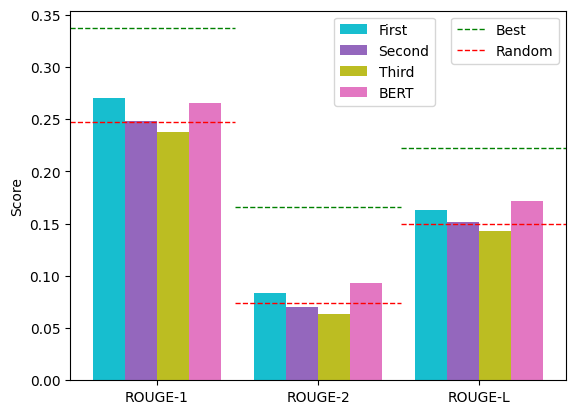

In [ ]:
plot_rouge([first_summary, second_summary, third_summary, summarized_docs_bert,
            random_summary, best_summary],
           ['First', 'Second', 'Third', 'BERT',
            'Random', 'Best'],
           summary_test
           )

# Exporting The Best Summary

The documents of the training set are summarized with the best summarizer (BERT Extractive Summarizer) first and then joined with the test summaries.

In [ ]:
summary_train = [bert_exctractive_summarizer(doc, num_sentences=n_sentences) if len(nltk.sent_tokenize(doc)) >= n_sentences
                 else doc for doc in tqdm(docs_train_full)]

  0%|          | 0/42403 [00:00<?, ?it/s]

In [ ]:
summarized_docs = summary_train + summarized_docs_bert

The new total and average number of sentences per summary are respectively:

In [ ]:
doc_count = [len(nltk.sent_tokenize(doc)) for doc in summarized_docs]

print(f'Number of sentences: {sum(doc_count)}\nAverage number of sentences per document: {np.mean(doc_count)}')

Number of sentences: 249869
Average number of sentences per document: 5.00869966123439


(The average number of sentences is not exactly 5 because there might be a slight difference in how NLTK and bert split documents into sentences)

The summarized docs are exported to the "Data" folder.

In [ ]:
with open(f'{base_path}/Text_Mining_Project_881765_933735/Data/summarized_docs', "wb") as fp:
  pickle.dump(summarized_docs, fp)